In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Dense, Flatten, Reshape, Conv2DTranspose, LeakyReLU, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

In [2]:
# Define the image directory
image_dir = r'E:\IT_solera\project_3\data\images\img_align_celeba\img_align_celeba'

In [3]:
# Define image size
image_size = (128, 128)

In [4]:
# Function to load and preprocess images
def load_images(image_dir, image_size, num_images=None):
    images = []
    for i, file_name in enumerate(os.listdir(image_dir)):
        if num_images and i >= num_images:
            break
        img_path = os.path.join(image_dir, file_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    images = np.array(images) / 255.0  # Normalize to [0, 1]
    return images

In [6]:
# Load a subset of images for demonstration
images = load_images(image_dir, image_size, num_images=2000)

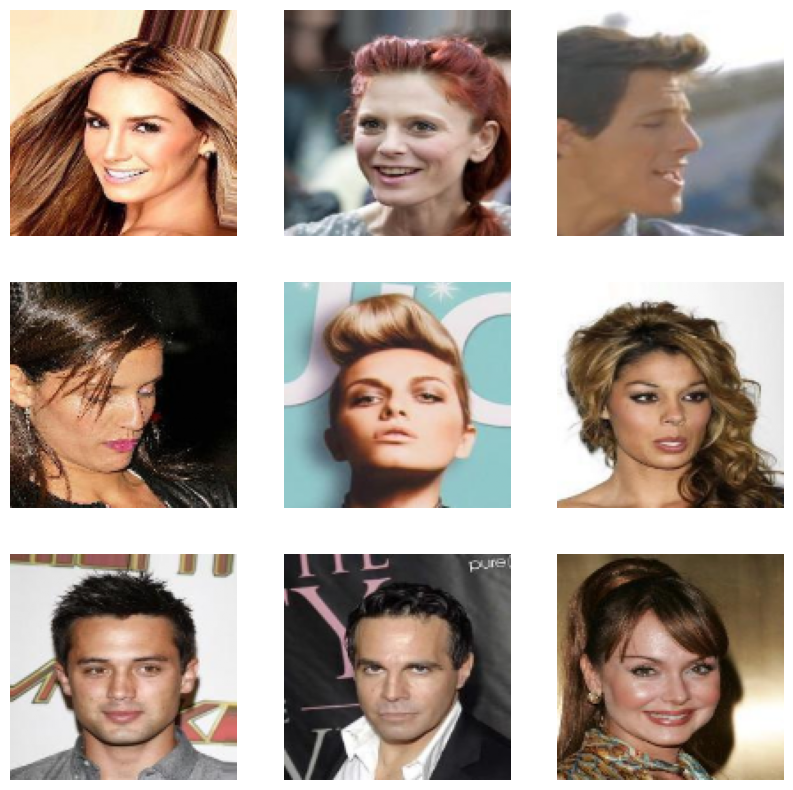

In [7]:
# Display some images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [8]:
# Function to create random occlusions on images
def add_occlusion(images, occlusion_size=(32, 32)):
    occluded_images = []
    for img in images:
        occluded_img = img.copy()
        h, w, _ = img.shape
        x = np.random.randint(0, w - occlusion_size[1])
        y = np.random.randint(0, h - occlusion_size[0])
        occluded_img[y:y + occlusion_size[0], x:x + occlusion_size[1]] = 0
        occluded_images.append(occluded_img)
    return np.array(occluded_images)

In [9]:
# Add occlusions to images
occluded_images = add_occlusion(images)

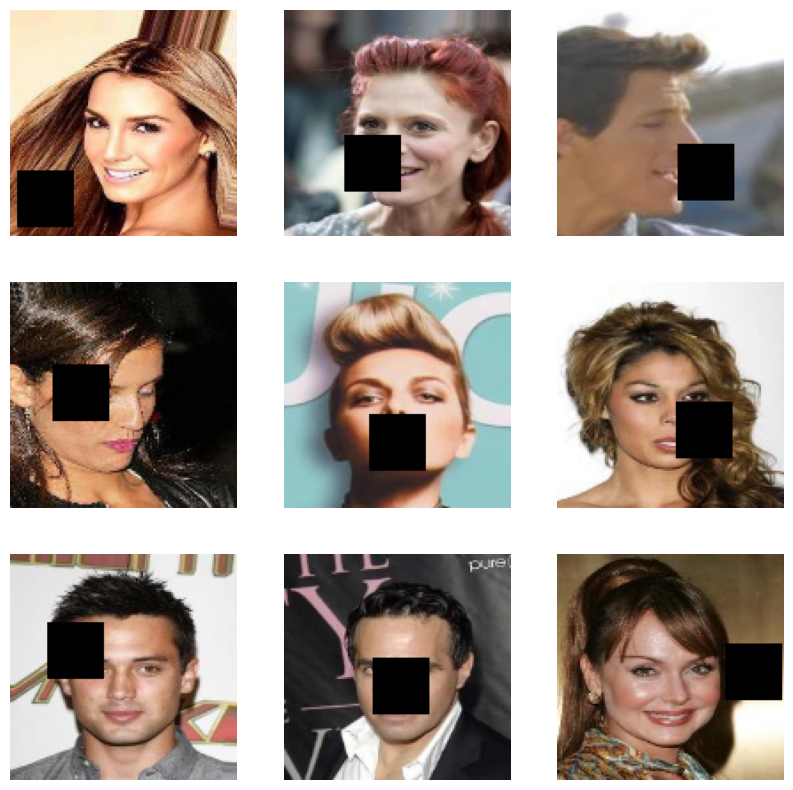

In [10]:
# Display original and occluded images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(occluded_images[i])
    plt.axis('off')
plt.show()

In [11]:
# CNN-based Inpainting

# Define CNN-based inpainting model
def build_cnn_inpainting_model(input_shape):
    model = Sequential()
    
    # Encoder
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    # Decoder
    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    
    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(UpSampling2D((2, 2)))
    
    model.add(Conv2D(3, (3, 3), padding='same'))
    model.add(Activation('sigmoid'))
    
    return model

In [12]:
input_shape = (image_size[0], image_size[1], 3)
cnn_inpainting_model = build_cnn_inpainting_model(input_shape)
cnn_inpainting_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError(), metrics=['accuracy'])

C:\Users\muham\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
cnn_inpainting_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 3)         │           1,731 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 128, 128, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,331,459 (5.08 MB)

 Trainable params: 1,331,459 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Training the CNN model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

history = cnn_inpainting_model.fit(occluded_images, images, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 719s 14s/step - accuracy: 0.7098 - loss: 0.0648 - val_accuracy: 0.8031 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 723s 14s/step - accuracy: 0.8086 - loss: 0.0119 - val_accuracy: 0.7896 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 626s 13s/step - accuracy: 0.8048 - loss: 0.0091 - val_accuracy: 0.8293 - val_loss: 0.0078 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 646s 13s/step - accuracy: 0.8206 - loss: 0.0074 - val_accuracy: 0.8179 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 609s 12s/step - accuracy: 0.8297 - loss: 0.0073 - val_accuracy: 0.8439 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 607s 12s/step - accuracy: 0.8415 - loss: 0.0062 - val_accuracy: 0.8582 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 613s 12s/step - accuracy: 0.8510 - loss: 0.0056 - 

In [15]:
# Save the model
cnn_inpainting_model.save('cnn_inpainting_model.h5')

In [16]:
# Evaluate the model
loss, accuracy = cnn_inpainting_model.evaluate(occluded_images, images)
print(f'Loss: {loss}, Accuracy: {accuracy}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.8937 - loss: 0.0022
Loss: 0.0023824817035347223, Accuracy: 0.8934200406074524


In [17]:
# Predict on occluded images
reconstructed_images = cnn_inpainting_model.predict(occluded_images)

63/63 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step


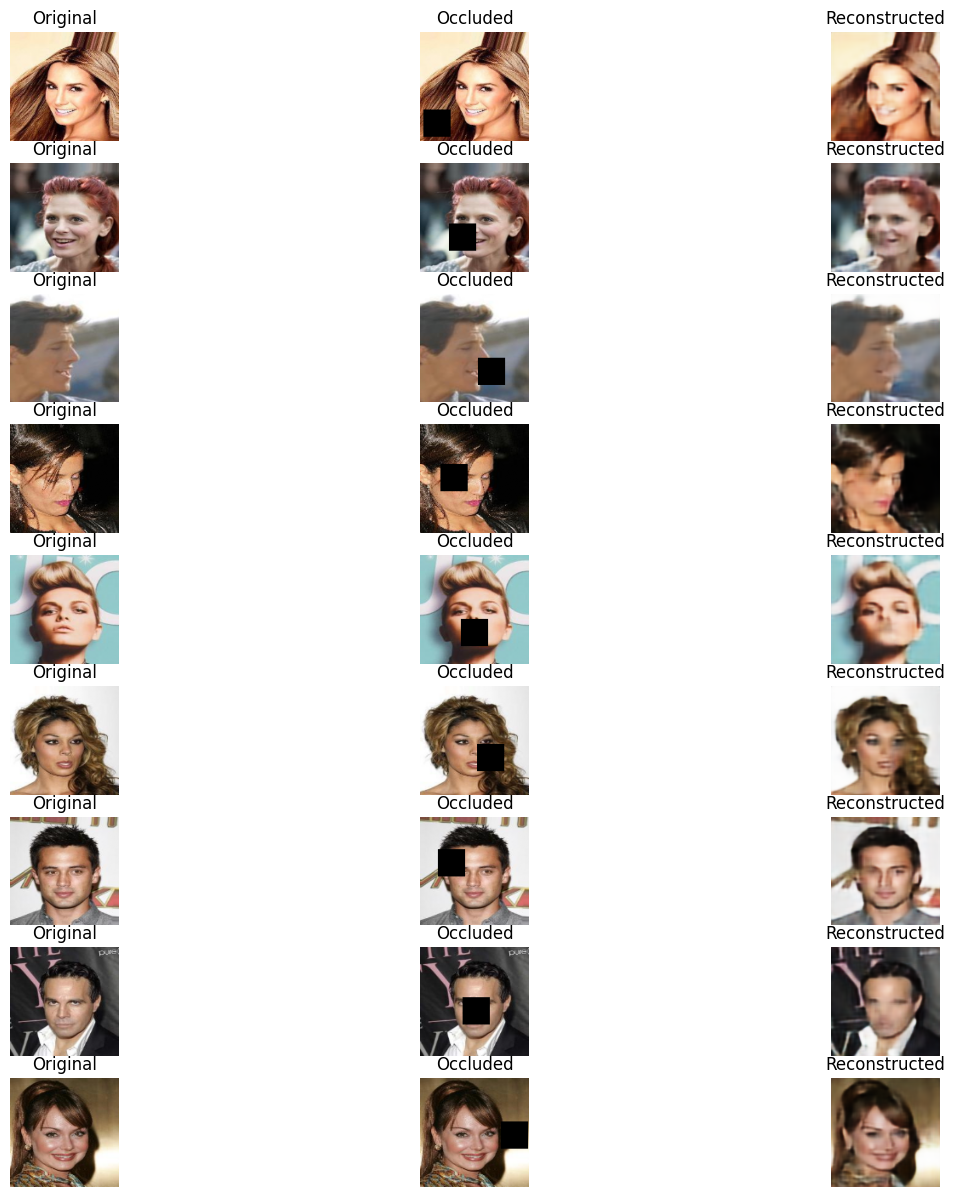

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(9, 3, i * 3 + 1)
    plt.imshow(images[i])
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(9, 3, i * 3 + 2)
    plt.imshow(occluded_images[i])
    plt.title('Occluded')
    plt.axis('off')
    
    plt.subplot(9, 3, i * 3 + 3)
    plt.imshow(reconstructed_images[i])
    plt.title('Reconstructed')
    plt.axis('off')

plt.show()


# GAN-based Inpainting (DeepFillv2-like Architecture)

In [2]:
def build_generator(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(64, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    return Model(inputs, outputs)

def build_discriminator(input_shape):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    
    return Model(inputs, x)

In [ ]:
# Build generator and discriminator
generator = build_generator(input_shape)
discriminator = build_discriminator(input_shape)

In [22]:
# Compile discriminator
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# Build and compile GAN
discriminator.trainable = False
gan_input = Input(shape=input_shape)
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')


In [24]:
# Display model summaries
generator.summary()
discriminator.summary()
gan.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 128, 128, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 743,939 (2.84 MB)

 Trainable params: 742,659 (2.83 MB)

 Non-trainable params: 1,280 (5.00 KB)

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │         131,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,233 (809.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 207,233 (809.50 KB)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_21 (Functional)           │ (None, 128, 128, 3)         │         743,939 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_23 (Functional)           │ (None, 1)                   │         207,233 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 951,172 (3.63 MB)

 Trainable params: 742,659 (2.83 MB)

 Non-trainable params: 208,513 (814.50 KB)

In [25]:
# Function to add random occlusions for training
def add_random_occlusion(image, occlusion_size=(32, 32)):
    occluded_image = image.copy()
    h, w, _ = image.shape
    x = np.random.randint(0, w - occlusion_size[1])
    y = np.random.randint(0, h - occlusion_size[0])
    occluded_image[y:y + occlusion_size[0], x:x + occlusion_size[1]] = 0
    return occluded_image

In [26]:
# Function to generate batches of occluded and original images
def generate_batches(images, batch_size, occlusion_size=(32, 32)):
    while True:
        idx = np.random.randint(0, images.shape[0], batch_size)
        batch_images = images[idx]
        batch_occluded = np.array([add_random_occlusion(img, occlusion_size) for img in batch_images])
        yield batch_occluded, batch_images

In [43]:
# Hyperparameters
batch_size = 16  # Reduce batch size to lower memory usage
epochs = 50   # Decrease the number of epochs to reduce total training time
sample_interval = 10  # More frequent sampling for monitoring

print(f"Batch size: {batch_size}")
print(f"Epochs: {epochs}")
print(f"Sample interval: {sample_interval}")

Batch size: 16
Epochs: 50
Sample interval: 10


In [44]:
import os

# Function to save generated images
def sample_images(epoch, generator, occluded_images, save_path='images/'):
    # Create the directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    fake_images = generator.predict(occluded_images)
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    for i in range(3):
        for j in range(3):
            if i * 3 + j < len(fake_images):
                axs[i, j].imshow(fake_images[i * 3 + j])
            axs[i, j].axis('off')
    plt.show()
    fig.savefig(f"{save_path}gan_images_{epoch}.png")
    plt.close()


In [1]:
# Training loop
for epoch in range(epochs):
    # Select a random batch of images
    occluded_images, original_images = next(generate_batches(images, batch_size))
    
    # Generate fake (reconstructed) images
    fake_images = generator.predict(occluded_images)
    
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(original_images, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train the generator
    g_loss = gan.train_on_batch(occluded_images, np.ones((batch_size, 1)))
    
    # Print progress
    print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")
    
    # Save generated images at intervals
    if epoch % sample_interval == 0:
        sample_images(epoch, generator, occluded_images)


NameError: name 'epochs' is not defined

In [46]:
# Generate reconstructed images using GAN generator
gan_reconstructed_images = generator.predict(occluded_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


ValueError: num must be an integer with 1 <= num <= 9, not 10

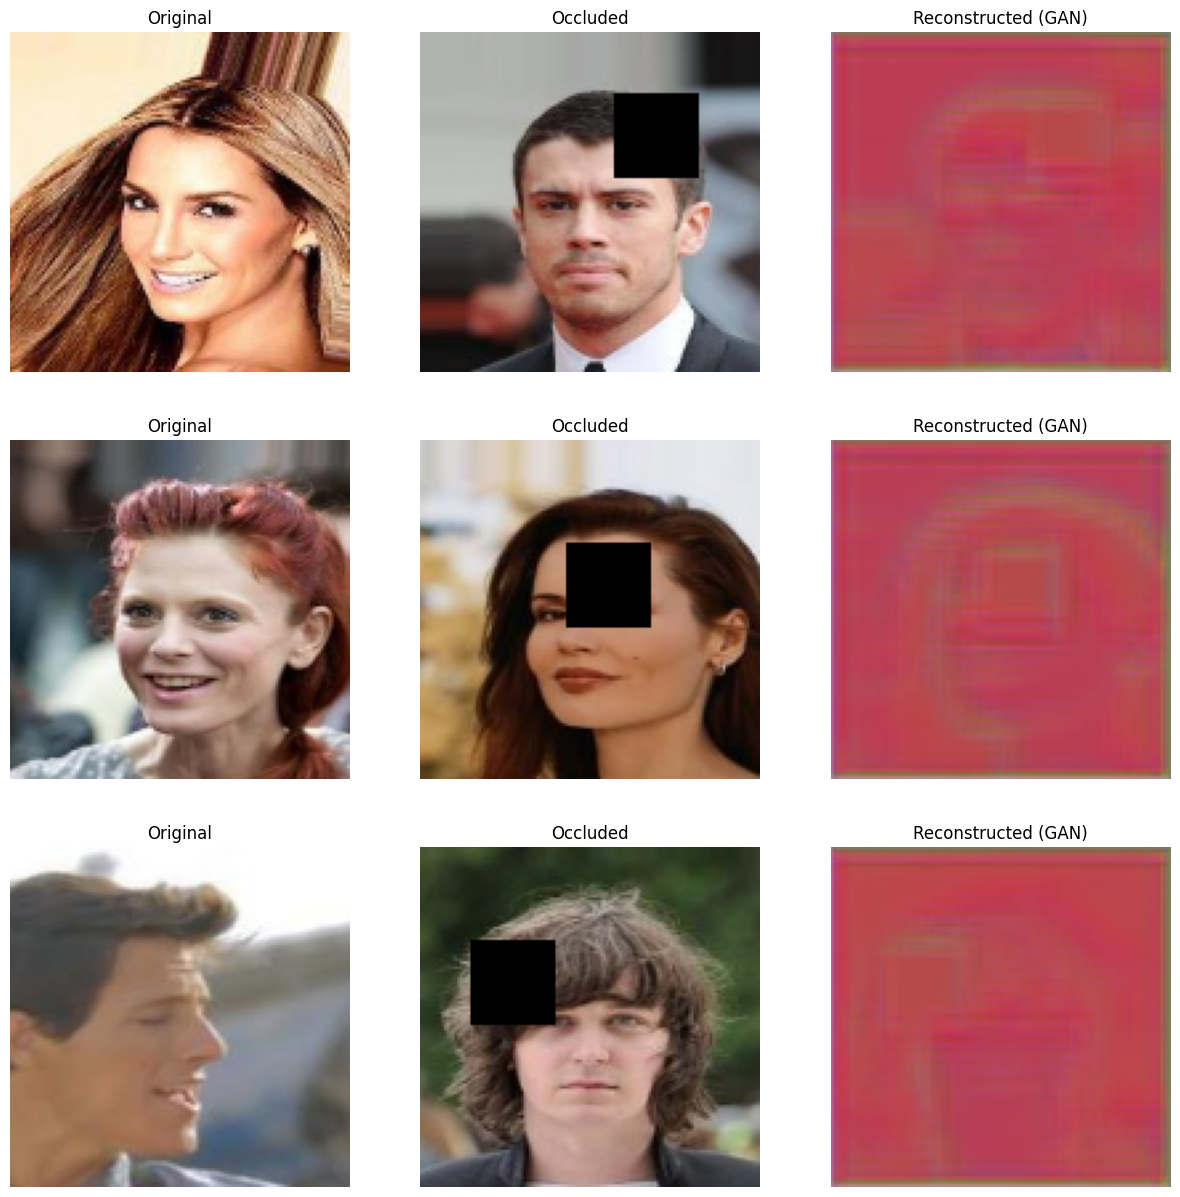

In [47]:
# Display original, occluded, and GAN-reconstructed images
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i * 3 + 1)
    plt.imshow(images[i])
    plt.title('Original')
    plt.axis('off')
    
    plt.subplot(3, 3, i * 3 + 2)
    plt.imshow(occluded_images[i])
    plt.title('Occluded')
    plt.axis('off')
    
    plt.subplot(3, 3, i * 3 + 3)
    plt.imshow(gan_reconstructed_images[i])
    plt.title('Reconstructed (GAN)')
    plt.axis('off')
plt.show()